In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
import pandas as pd
import requests
import time
import re

# Парсинг объявлений продажи квартир с сайта [bsn.ru](https://www.bsn.ru/build/sell/)

In [ ]:
type_list = []
square_list = []
floor_list = []
metro_list = []
price_list = []


for i in range(1,331):
  temp = requests.post('https://www.bsn.ru/build/sell/?page={}'.format(i))
  soap = BeautifulSoup(temp.text, "html.parser")
  table = soap.find('div', 
                   class_ = "estate-list")
  
  string = 'title text-overflow'
  for apartment in table.select('span.type-object, span.full-square, span.cost, span.subway, span.district, div.address-wrap'):
    if 'type-object' in apartment.get('class'):
      text = apartment.text.strip()
      if text == "студия":
        type_list.append(0)
      else:
        text = re.sub("[^0-9]", "", text)
        type_list.append(int(text))
    if 'full-square' in apartment.get('class'):
      square_list.append(float(apartment.text.replace(",", "").replace("м2", "").strip()))
    if 'cost' in apartment.get('class'):
      price_list.append(int(re.sub("[^0-9]", "", str(apartment.text.replace(" ", "").strip()))))
    if 'subway' in apartment.get('class'):
      metro_list.append(1)
    if 'district' in apartment.get('class'):
      metro_list.append(0)
    if 'address-wrap' in apartment.get('class'):
      text = apartment.find('a', 'title text-overflow').text
      regex = "[0-9]+ этаж"
      result = re.search(regex, text)
      sub_string = result.group(0)
      floor = re.sub("[^0-9]", "", sub_string)
      floor_list.append(int(floor))
      if not apartment.find('span', 'subway') and not apartment.find('span', 'district'):
        metro_list.append(0)

# Исследование (визуализация данных)

In [ ]:
print(len(type_list))
print(len(square_list))
print(len(floor_list))
print(len(metro_list))
print(len(price_list))

6600
6600
6600
6600
6600


In [ ]:
apartment_df = pd.DataFrame(
    {'Type': type_list,
     'Square': square_list,
     'Floor': floor_list,
     'Metro': metro_list,
     'Price': price_list
    })

In [ ]:
apartment_df

,Type,Square,Floor,Metro,Price
0,1,36.07,9,1,18641985
1,1,30.62,3,1,9399999
2,1,45.69,3,1,13900000
3,1,34.84,11,1,6043914
4,3,65.77,1,1,11307171
...,...,...,...,...,...
6595,0,35.36,9,0,6117280
6596,0,34.22,6,0,6228040
6597,0,35.10,6,0,6037200
6598,0,34.04,5,0,6195280


In [ ]:
apartment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600 entries, 0 to 6599
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Type    6600 non-null   int64  
 1   Square  6600 non-null   float64
 2   Floor   6600 non-null   int64  
 3   Metro   6600 non-null   int64  
 4   Price   6600 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 257.9 KB


In [ ]:
apartment_df.to_csv("apartment.csv", encoding="utf-8", index=False)

In [2]:
apartment_df = pd.read_csv('apartment.csv') 

<Axes: >

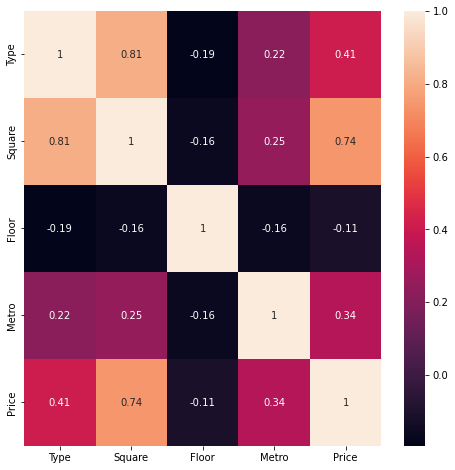

In [3]:
plt.figure(figsize=(8,8))
sns.heatmap(apartment_df.corr(), annot=True)

In [ ]:
import plotly.express as px
fig = px.pie(apartment_df, values=apartment_df['Type'].value_counts().tolist(), names=apartment_df['Type'].value_counts().keys().tolist(),
             title='The number of all apartment types')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [5]:
import plotly.express as px
fig = px.pie(apartment_df, values=apartment_df['Metro'].value_counts().tolist(), names=apartment_df['Metro'].value_counts().keys().tolist(),
             title='Percentage of subway availability')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [8]:
df_new

,Type,Square,Floor,Metro,Price
0,1,36.07,9,1,18641985
1,1,30.62,3,1,9399999
2,1,45.69,3,1,13900000
3,1,34.84,11,1,6043914
4,3,65.77,1,1,11307171
...,...,...,...,...,...
6595,0,35.36,9,0,6117280
6596,0,34.22,6,0,6228040
6597,0,35.10,6,0,6037200
6598,0,34.04,5,0,6195280


# Статистические гипотезы

In [9]:
from scipy import stats

## Влияние наличия метро на ценообразование квартир. Критерий Флингера-Килина. Гипотеза о равенстве средних значений

In [62]:
# Сохраним в отдельные переменные выборки, которые собираемся сравнивать.
x = np.log(df_new[df_new["Metro"] == 1]["Price"])
y = np.log(df_new[df_new["Metro"] == 0]["Price"])

In [56]:
import plotly.graph_objects as go
def two_histograms(x, y):
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=x, name="Subway"))
    fig.add_trace(go.Histogram(x=y, name="No subway"))
    fig.add_vline(x.mean(), line_width=3, line_dash="dash", line_color="blue")
    fig.add_vline(y.mean(), line_width=3, line_dash="dash", line_color="red")
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.75)
    fig.show()

In [59]:
# Пунктирными линиями указываются средние значения выборок.
two_histograms(x, y)

In [63]:
# Проверим гипотезу о равенстве дисперсий векторов, которые мы определили выше.
res = stats.fligner(x, y)
print('p-value: ', res[1])

p-value:  2.0143550638333788e-119


In [64]:
# Проверим гипотезу о равенстве средних значений для несвязных выборок.
res = stats.ttest_ind(x, y, equal_var=True)
print('p-value: ', res[1])

p-value:  0.0


## Корреляция цены и квадратуры квартир

In [6]:
fig = px.scatter(apartment_df, x="Square", y="Price", title='Price', size_max=60)
fig.show()

In [7]:
df_new = apartment_df
df_new = df_new[df_new.Square < 100]
fig = px.scatter(df_new, x="Square", y="Price", title='Price', size_max=60)
fig.show()

In [65]:
# Вычисляет коэффициент корреляции Пирсона и значение p для проверки корреляции.
res = stats.pearsonr(df_new['Price'], df_new['Square'])
print('Pearson rho: ', res[0])
print('p-value: ', res[1])

Pearson rho:  0.6868288496901789
p-value:  0.0


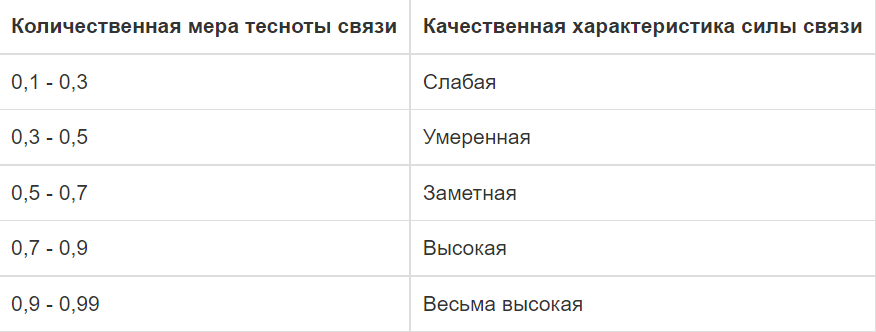

In [66]:
# Шкала Чеддока для определения силы кореляции по Пирсону
from IPython.display import Image
Image('Chaddock_scale.png')

# Обучение моделей машинного обучения

In [ ]:
from sklearn import metrics
from scipy import stats

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Строим 3 регрессионные модели
lin_reg = LinearRegression()
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()

In [ ]:
X = df_new.drop('Price', axis=1)
y = df_new['Price']

In [ ]:
from sklearn.model_selection import KFold
# Разделим набор данных на 4 блока с помощью KFold
kf = KFold(n_splits=4, shuffle=True, random_state=42)

In [ ]:
lin_reg_mae = []
lin_reg_mse = []
lin_reg_r2 = []

dt_reg_mae = []
dt_reg_mse = []
dt_reg_r2 = []

rf_reg_mae = []
rf_reg_mse = []
rf_reg_r2 = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Линейная регрессия
    lin_reg.fit(X_train, y_train)
    lin_reg_mae.append(mean_absolute_error(y_test, lin_reg.predict(X_test)))
    lin_reg_mse.append(mean_squared_error(y_test, lin_reg.predict(X_test)))
    lin_reg_r2.append(r2_score(y_test, lin_reg.predict(X_test)))
    
    # Дерево решений
    dt_reg.fit(X_train, y_train)
    dt_reg_mae.append(mean_absolute_error(y_test, dt_reg.predict(X_test)))
    dt_reg_mse.append(mean_squared_error(y_test, dt_reg.predict(X_test)))
    dt_reg_r2.append(r2_score(y_test, dt_reg.predict(X_test)))
    
    # Случайный лес
    rf_reg.fit(X_train, y_train)
    rf_reg_mae.append(mean_absolute_error(y_test, rf_reg.predict(X_test)))
    rf_reg_mse.append(mean_squared_error(y_test, rf_reg.predict(X_test)))
    rf_reg_r2.append(r2_score(y_test, rf_reg.predict(X_test)))

# Рассчитаем средние значения MAE, MSE и R2 для каждой модели по 4 блокам.
lin_reg_avg_mae = np.mean(lin_reg_mae)
lin_reg_avg_mse = np.mean(lin_reg_mse)
lin_reg_avg_r2 = np.mean(lin_reg_r2)

dt_reg_avg_mae = np.mean(dt_reg_mae)
dt_reg_avg_mse = np.mean(dt_reg_mse)
dt_reg_avg_r2 = np.mean(dt_reg_r2)

rf_reg_avg_mae = np.mean(rf_reg_mae)
rf_reg_avg_mse = np.mean(rf_reg_mse)
rf_reg_avg_r2 = np.mean(rf_reg_r2)

# Выведем результат
print('Linear Regression:')
print('MAE:', lin_reg_avg_mae)
print('MSE:', lin_reg_avg_mse)
print('R2:', lin_reg_avg_r2)
print()

print('Decision Tree Regression:')
print('MAE:', dt_reg_avg_mae)
print('MSE:', dt_reg_avg_mse)
print('R2:', dt_reg_avg_r2)
print()

print('Random Forest Regression:')
print('MAE:', rf_reg_avg_mae)
print('MSE:', rf_reg_avg_mse)
print('R2:', rf_reg_avg_r2)
print()

Linear Regression:
MAE: 1622129.2993558585
MSE: 8623227182046.004
R2: 0.6457649181542142

Decision Tree Regression:
MAE: 595936.3159552842
MSE: 5034953960826.472
R2: 0.7943722588950615

Random Forest Regression:
MAE: 577015.0526569837
MSE: 3626126286656.1885
R2: 0.8544131505360546



## Попытка автоматизизации подбора гиперпараметров для Random Forest

In [ ]:
# Масштабирование данных
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

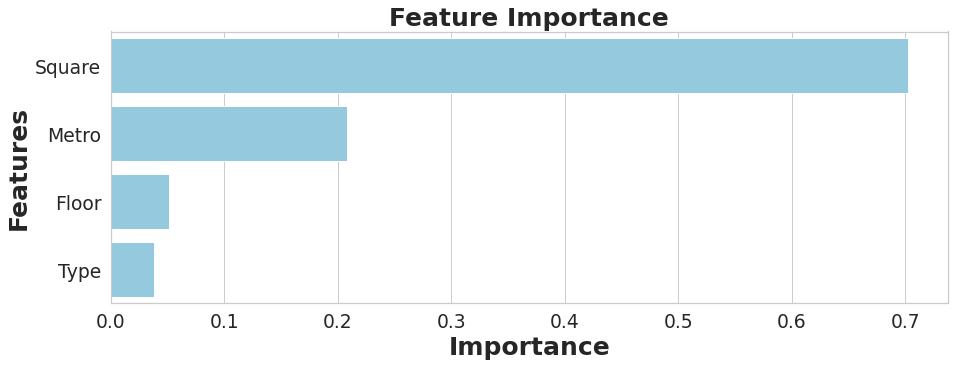

None

,Features,Gini-Importance
0,Square,0.702248
1,Metro,0.208272
2,Floor,0.051658
3,Type,0.037822


In [ ]:
feats = {}
for feature, importance in zip(df_new.columns, rf_reg.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rf_reg, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled, y_train)
rfc_2 = rs.best_estimator_
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 18,
 'min_samples_leaf': 7,
 'max_features': 'sqrt',
 'max_depth': 7,
 'bootstrap': False}

In [ ]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,18,7,sqrt,7,False,0.588631,1
1,500,18,7,log2,7,True,0.588512,2
2,1000,12,7,sqrt,10,True,0.586580,3
3,300,28,7,log2,13,True,0.586076,4
4,700,23,7,log2,15,False,0.583697,5
5,700,2,2,log2,11,True,0.577268,6
6,600,50,2,sqrt,7,False,0.577206,7
7,1000,44,2,sqrt,9,True,0.575726,8
8,200,12,2,log2,4,True,0.575628,9
9,700,12,2,sqrt,13,False,0.574957,10


In [ ]:
from sklearn.model_selection import GridSearchCV
n_estimators = [300, 500, 700, 1000]
max_features = ['log2', 'sqrt']
max_depth = [7, 10, 11, 13, 15]
min_samples_split = [2, 12, 18, 23, 28]
min_samples_leaf = [2,7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rf_reg, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


{'bootstrap': False,
 'max_depth': 7,
 'max_features': 'log2',
 'min_samples_leaf': 7,
 'min_samples_split': 12,
 'n_estimators': 500}

In [ ]:
y_pred_rs = rs.best_estimator_.predict(X_test_scaled)
y_pred_gs = gs.best_estimator_.predict(X_test_scaled)

In [ ]:
y_test = np.array(y_test)
y_test

array([13900000,  6043914, 11307171, ...,  6772480,  6679640,  5402080])

In [ ]:
print(r2_score(y_test, y_pred_rs))
print(r2_score(y_test, y_pred_gs))

0.8237552190063974
0.8245288369040559


In [ ]:
print(mean_absolute_error(y_test, y_pred_rs))
print(mean_absolute_error(y_test, y_pred_gs))

852041.4037533404
853169.4108203433
